# Portfolio Optimization

**Portfolio**: A portfolio is a collection of financial instruments like stocks, bonds, commodities, cash and cash equivalents , as well as their fund counterparts. [Investopedia]

**Returns**: It refers to the gain or loss on our asset/portfolio over a fixed time frame. In this analysis, we make a return as the percentage change in the closing price of the asset over the previous day’s closing price. We will compute the returns using .pct_change() function in python. #https://www.analyticsvidhya.com/blog/2021/04/portfolio-optimization-using-mpt-in-python/

**Portfolio optimization**: The process of creating a portfolio of assets, for which your investment has the maximum return and minimum risk.

But how do we decide out of an infinite possible combinations for portfolios, the one which is optimum?

**Modern Portfolio Theory**, or also known as mean-variance analysis is a mathematical process which allows the user to maximize returns for a given risk level.

* It was formulated by H. Markowitz and while it is not the only optimization technique known, it is the most widely used.

* MPT assumes that all investors are risk-averse, i.e, if there is a choice between low risk and high risk portfolios with the same returns, an investor will choose one with the low risk.

Specifically, given the historical data of $n$ stocks:
* $\tilde{r}_i$: Reward from stock $i$ (random variable)
* $\mu_i = {\rm E}(\tilde{r}_i)$: expected reward from stock $i$
* ${\rm Var}(\tilde{r}_i):$ variance in reward from stock $i$
* $\sigma_{ij} = {\rm E}((\tilde{r}_i - \mu_i)(\tilde{r}_j - \mu_j)) = {\rm  Cov}(\tilde{r}_i,\tilde{r}_j)$. Note that $\sigma_{ii} = {\rm Var}(\tilde{r}_i):$
* Budget $B$, target $\beta$ on expected portfolio reward

we want to decide the amount to invest in stock $i$---denoted as $x_i$---to minimize total portfolio variance so that:
* expected reward of total portfolio is above target β
* total amount invested stay within our budget

(Note that we do not consider short sales here)

We can formulate the portfolio problem as follows:

$$
\begin{align}
\min\ & \boldsymbol{x}^\top \boldsymbol{\Sigma} \boldsymbol{x}\\
\mbox{s.t.}\ & \boldsymbol{\mu}^\top \boldsymbol{x} \geq \beta\\
&\boldsymbol{1}^\top \boldsymbol{x} \leq B\\
&\boldsymbol{x} \leq \boldsymbol{1}\\
&\boldsymbol{x} \geq \boldsymbol{0}
\end{align}
$$

Now let's go through some fundamental terms in portfolio optimization step by step and solve the above model at the end. 

### Step 1 Pull the stock price data from yahoo finance

**Prompt**:

I want to use the Markowitz model to do the portfolio optimization. To do so, the first step is to pull the stock price data from yahoo finance, for example, the Adj Close price from 1st January 2010 to 31st December 2017 for the following stocks:
['HSBC','JPM','AAPL','WMT','AMZN','MSFT']

Can you provide the code to obtain the stock data?

In [3]:
import yfinance as yf
import pandas as pd

# Define the tickers and the time period
tickers = ['SPY', 'VGK', 'EEM', 'VPL', 'AGG', 'TLT', 'LQD', 'GLD', 'SLV', 'VNQ', 'GSG']
start_date = '2010-01-01'
end_date = '2025-03-31'

# Pull the Adjusted Close price data
stock_data = yf.download(tickers, start=start_date, end=end_date)['Close']

# Save the data to a CSV file
stock_data.to_csv('stock_data.csv')

print("Stock data has been successfully fetched and saved.")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  11 of 11 completed


Stock data has been successfully fetched and saved.


In [4]:
stock_data

Ticker,AGG,EEM,GLD,GSG,LQD,SLV,SPY,TLT,VGK,VNQ,VPL
Date,,,,,,,,,,,
2010-01-04,68.482216,31.084091,109.800003,32.700001,60.778145,17.230000,85.768456,58.893299,29.452465,24.488726,34.077206
2010-01-05,68.793701,31.309710,109.699997,33.029999,61.068417,17.510000,85.995506,59.273647,29.405310,24.461245,34.232002
2010-01-06,68.753960,31.375210,111.510002,33.270000,60.888447,17.860001,86.056046,58.480186,29.582150,24.417273,34.386772
2010-01-07,68.674431,31.193262,110.820000,33.110001,60.963890,17.889999,86.419296,58.578545,29.393509,24.681129,34.148151
2010-01-08,68.714211,31.440714,111.370003,33.180000,61.097454,18.150000,86.706871,58.552265,29.688267,24.499733,34.515774
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,98.360001,44.779999,277.250000,22.440001,108.290001,29.959999,574.080017,89.769997,71.730003,90.728004,74.690002
2025-03-25,98.449997,44.650002,278.470001,22.459999,108.400002,30.580000,575.460022,89.760002,72.160004,89.709999,75.089996
2025-03-26,98.209999,44.380001,278.239990,22.440001,107.959999,30.530001,568.590027,89.169998,71.139999,90.059998,74.410004


**Prompt**
Can you provide code to plot the normalized returns to have a visualization of the data?

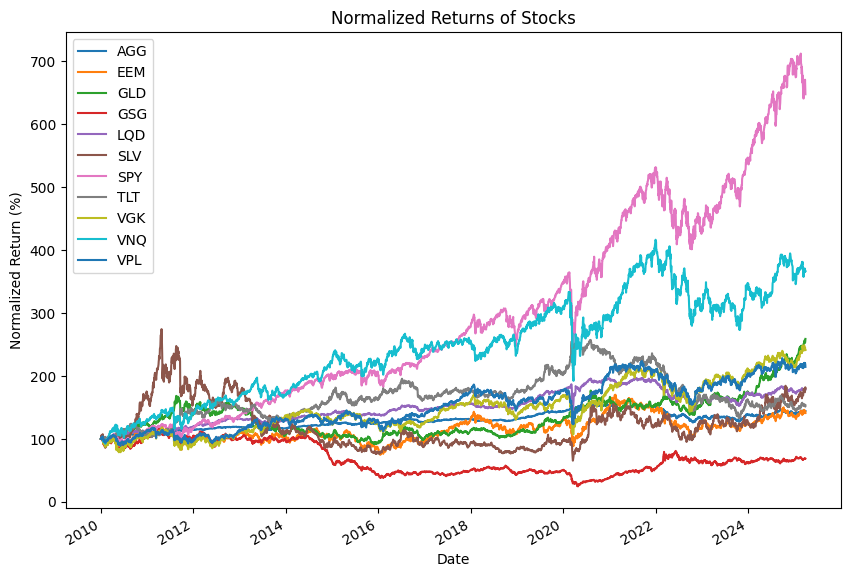

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'stock_data.csv' is the file where the stock data is saved
stock_data = pd.read_csv('stock_data.csv', index_col='Date', parse_dates=True)

# Calculate normalized returns
normalized_data = stock_data / stock_data.iloc[0] * 100

# Plot the normalized returns
normalized_data.plot(figsize=(10, 7))
plt.title('Normalized Returns of Stocks')
plt.xlabel('Date')
plt.ylabel('Normalized Return (%)')
plt.legend(loc='best')
plt.show()

### Step 2: Calculate percentage change (dayly return) and average return in stock prices

Next, we calculate the percentage change in stock prices everyday. You will notice that that we take the log of percentage change.

But why take log?

The reason for this is that log of the returns is time additive.

That is, If $r_{13}$ is the returns for time between $t_3$ and $t_1$. $r_{12}$ is the returns between $t_1$ and $t_2$ and $r_{23}$ is the returns between $t_2$ and $t_3$.

Then, $\log(r_{13}) = \log(r_{12}) + \log(r_{23})$

For example:,
If $p_1 = 100, p_2 = 110$ and $p_3 = 120$, where $p_1$ is price of stock in time 1

Then:

$$ \log(r_{12}) = \ln(p2/p1) = \ln(110/100) = 9.53\%, $$

$$ \log(r_{23}) = \ln(120/110) = 8.7%$$ 
and

$$ \log(r_{13}) = \log(r_{12}) + \log(r_{23}) = 9.53 + 8.7 = 18.23%,$$ 

which is same as $\ln(120/100)$.

This means a log change of +0.1 today and then -0.1 tomorrow will give you the same value of stock as yesterday. This is not true if you simply compute percentage change.

It is common practice in portfolio optimization to take log of returns for calculations of covariance and correlation.

This can be easily achieved by using `pct_change()`. 

**Prompt**
Could you please provide code to calculate the percentage change, i.e., daily return and average daily and yearly return in stock prices?

In [6]:
import pandas as pd

# Assuming 'stock_data.csv' is the file where the stock data is saved
stock_data = pd.read_csv('stock_data.csv', index_col='Date', parse_dates=True)

# Calculate daily returns
daily_returns = stock_data.pct_change()

# Calculate average daily return
average_daily_return = daily_returns.mean()

# Calculate average yearly return, assuming 252 trading days in a year
average_yearly_return = average_daily_return * 252

print("Average Daily Return:")
print(average_daily_return)

print("\nAverage Yearly Return:")
print(average_yearly_return)

Average Daily Return:
AGG    0.000100
EEM    0.000181
GLD    0.000296
GSG   -0.000010
LQD    0.000163
SLV    0.000319
SPY    0.000546
TLT    0.000157
VGK    0.000317
VNQ    0.000424
VPL    0.000258
dtype: float64

Average Yearly Return:
AGG    0.025187
EEM    0.045600
GLD    0.074511
GSG   -0.002646
LQD    0.041061
SLV    0.080309
SPY    0.137480
TLT    0.039607
VGK    0.079811
VNQ    0.106912
VPL    0.064939
dtype: float64


### Step 3: Calculate variance/covariance in stock prices

The variance in prices of stocks are an important indicator of how volatile this investment will be (how returns can fluctuate).

It can be calculated for each company by using built in `.var()` function. Under the hood, the formula implemented by this function is given by:
$
\sigma^2 = \sum_{i = 1}^{N}(x_i - \bar{x})^2/(N - 1)
$

The covariance between Apple and Apple, or Nike and Nike is the variance of that asset.

The next step is to create the correlation matrix. Correlation ranges from -1 to 1.

A correlation of -1 means negative relation, i.e, if correlation between Asset A and Asset B is -1, if Asset A increases, Asset B decreases.

A correlation of +1 means positive relation, i.e, if correlation between Asset A and Asset B is 1, if Asset A increases, Asset B increases.

A correlation of 0 means no relation, i.e, if correlation between Asset A and Asset B is 0, they dont have any effect on each other.

In [7]:
# Assuming 'daily_returns' is the DataFrame of daily returns calculated previously
# Calculate variance of the stock prices
variance = daily_returns.var()

# Calculate covariance matrix of the stock prices
covariance_matrix = daily_returns.cov()

# Display the results
print("Variance of Stock Prices:\n", variance)
print("\nCovariance Matrix of Stock Prices:\n", covariance_matrix)

Variance of Stock Prices:
 AGG    0.000009
EEM    0.000183
GLD    0.000095
GSG    0.000176
LQD    0.000024
SLV    0.000329
SPY    0.000115
TLT    0.000092
VGK    0.000173
VNQ    0.000169
VPL    0.000117
dtype: float64

Covariance Matrix of Stock Prices:
               AGG           EEM       GLD       GSG       LQD       SLV  \
AGG  8.948902e-06  8.170203e-07  0.000009 -0.000002  0.000012  0.000010   
EEM  8.170203e-07  1.825944e-04  0.000023  0.000077  0.000011  0.000081   
GLD  8.767918e-06  2.258774e-05  0.000095  0.000029  0.000013  0.000140   
GSG -2.285148e-06  7.744054e-05  0.000029  0.000176  0.000001  0.000083   
LQD  1.218201e-05  1.082037e-05  0.000013  0.000001  0.000024  0.000019   
SLV  1.010747e-05  8.106863e-05  0.000140  0.000083  0.000019  0.000329   
SPY  3.282225e-08  1.137470e-04  0.000006  0.000056  0.000009  0.000044   
TLT  2.341320e-05 -3.465128e-05  0.000021 -0.000030  0.000031  0.000011   
VGK  5.488707e-07  1.461873e-04  0.000017  0.000073  0.000011  0.00007

### Step 4: Solve the optimization model

**Prompt**
Assume the role of a data engineer specialized in data and prescriptive analytics. You are proficient in constructing mathematical models and adept at programming and solving these models using the Gurobi library. In our subsequent interactions, you will be tasked with coding various optimization models utilizing the Gurobi library. Your objectives are to ensure accurate results and adhere to the following guidelines:
1. Define each optimization model as a function.
2. Generate random parameters when specific parameters are not provided.
3. After solving each optimization problem, verify the problem status. If the status is "OPTIMAL", include code snippets to retrieve and display the optimal solutions and the objective value.
4. Disable output logging by setting the "OutputFlag" to 0.
5. Present the results in a concise and clear format, utilizing tables or graphical representations when beneficial.
6. Strive for code efficiency, utilizing the minimal amount of code necessary for model programming.
7. If possible, use “addVars” for non-scalar decision variables and use “addConstrs” for a batch of constraints. Also, please use “quicksum” instead of “sum”.
8. Be careful of the indices given that Python starts from 0 but most of the models start from 1. 
9. Make sure the code you provided fulfills all the requirements, i.e., a complete code should be provided. 

Given the historical data of $n$ stocks:
* $\tilde{r}_i$: Reward from stock $i$ (random variable)
* $\mu_i = {\rm E}(\tilde{r}_i)$: expected reward from stock $i$
* ${\rm Var}(\tilde{r}_i):$ variance in reward from stock $i$
* $\sigma_{ij} = {\rm E}((\tilde{r}_i - \mu_i)(\tilde{r}_j - \mu_j)) = {\rm  Cov}(\tilde{r}_i,\tilde{r}_j)$. Note that $\sigma_{ii} = {\rm Var}(\tilde{r}_i):$
* Budget $B$, target $\beta$ on expected portfolio reward

we want to decide the amount to invest in stock $i$---denoted as $x_i$---to minimize total portfolio variance so that:
* expected reward of total portfolio is above target β
* total amount invested stay within our budget

We can formulate the portfolio problem as follows:

$$
\begin{align}
\min\ & \boldsymbol{x}^\top \boldsymbol{\Sigma} \boldsymbol{x}\\
\mbox{s.t.}\ & \boldsymbol{\mu}^\top \boldsymbol{x} \geq \beta\\
&\boldsymbol{1}^\top \boldsymbol{x} \leq B\\
&\boldsymbol{x} \leq \boldsymbol{1}\\
&\boldsymbol{x} \geq \boldsymbol{0}
\end{align}
$$

In [11]:
from gurobipy import Model, GRB, quicksum

def optimize_portfolio(mu, Sigma, B, beta):
    n = len(mu)  # Number of stocks
    m = Model("Portfolio Optimization")
    m.setParam('OutputFlag', 0)  # Disable Gurobi's output to console
    
    # Decision variables: Amount to invest in each stock
    x = m.addVars(n, lb=0, ub=1, name="x")

    # Objective: Minimize portfolio variance
    portfolio_variance = quicksum(Sigma[i, j] * x[i] * x[j] for i in range(n) for j in range(n))
    m.setObjective(portfolio_variance, GRB.MINIMIZE)

    # Constraint: Expected return of the portfolio is at least beta
    m.addConstr(quicksum(mu[i] * x[i] for i in range(n)) >= beta, "MinReturn")

    # Constraint: Total investment does not exceed budget
    m.addConstr(quicksum(x[i] for i in range(n)) == B, "Budget")

    m.optimize()

    if m.status == GRB.OPTIMAL:
        print("Optimal solution found with objective value:", m.objVal)
        return {i: x[i].X for i in range(n)}
    else:
        print("Optimal solution not found. Status code:", m.status)
        return None

# Example usage
mu = [0.1, 0.2, 0.15]  # Expected returns
Sigma = {(0, 0): 0.02, (0, 1): 0.01, (0, 2): 0.01,  # Covariance matrix
         (1, 0): 0.01, (1, 1): 0.03, (1, 2): 0.02,
         (2, 0): 0.01, (2, 1): 0.02, (2, 2): 0.04}
B = 1  # Total investment budget
beta = 0.18  # Minimum expected return

# Convert Sigma to a 2D list or array if needed before passing to the function
optimized_portfolio = optimize_portfolio(mu, Sigma, B, beta)
optimized_portfolio

Optimal solution found with objective value: 0.023163636386069428


{0: 0.18181778307053856, 1: 0.7818177846511261, 2: 0.03636443227833354}

In [9]:
# Example usage with previous data
mu = average_yearly_return.values
Sigma = covariance_matrix.values
B = 1  # Budget
beta = 0.2  # Target expected return

portfolio_strategy = optimize_portfolio(mu, Sigma, B, beta)
print("Optimal Portfolio Strategy:", portfolio_strategy)

Optimal solution not found. Status code: 3
Optimal Portfolio Strategy: None


### Step 5: Sensitivity analysis

What if we set different target $\beta$? For example, $\beta \in \{0.001, 0.002, 0.003, \ldots, 0.300\}$. We then need to do the sensitivity analysis. 

In other words, we solve the problem for each $\beta$ and evaluate the corresponding solution. 

**Prompt**
Could you please provide code to do sensitivity analysis for the parameter beta, assuming the range of beta is [0.001,0.3]? 

After that, for each portfolio strategy associated with each beta, please calculate its average yearly return and average yearly standard deviation and plot the efficient frontier.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming mu, Sigma, B are defined as per your data
beta_values = np.linspace(0.001, 0.3, 50)  # Adjust the range and step as necessary
avg_returns = []
std_devs = []

for beta in beta_values:
    portfolio_strategy_dict = optimize_portfolio(mu, Sigma, B, beta)  # Assuming this returns a dict
    # Convert portfolio_strategy from dict to an ordered list or array
    portfolio_strategy = np.array([portfolio_strategy_dict[i] for i in sorted(portfolio_strategy_dict)])
    avg_return = np.dot(mu, portfolio_strategy)
    std_dev = np.sqrt(np.dot(portfolio_strategy.T, np.dot(Sigma, portfolio_strategy)))
    avg_returns.append(avg_return)
    std_devs.append(std_dev)


# Plotting the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(std_devs, avg_returns, 'o--')
plt.title('Efficient Frontier')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Average Yearly Return')
plt.grid(True)
plt.show()

Optimal solution found with objective value: 8.040970362000583e-06
Optimal solution found with objective value: 8.040969414906428e-06
Optimal solution found with objective value: 8.040968045965795e-06
Optimal solution found with objective value: 8.040966850867784e-06
Optimal solution found with objective value: 8.040968768760405e-06
Optimal solution found with objective value: 8.066561288008109e-06
Optimal solution found with objective value: 8.436914796942585e-06
Optimal solution found with objective value: 9.209739629853585e-06
Optimal solution found with objective value: 1.0549901828522836e-05
Optimal solution found with objective value: 1.2489977401949324e-05
Optimal solution found with objective value: 1.4950967277652446e-05
Optimal solution found with objective value: 1.7765582105249958e-05
Optimal solution found with objective value: 2.0928361601095285e-05
Optimal solution found with objective value: 2.4439109836476456e-05
Optimal solution found with objective value: 2.829808065

TypeError: 'NoneType' object is not iterable

Efficient frontier is a graph with ‘returns’ on the Y-axis and ‘Risk’ on the X-axis. It shows us the maximum return we can get for a set level of risk, or conversely, the risk that we need to accept for certain level of returns.

Any sensible investor wants to maximize his return, even if it is a tradeoff with some level of risk.

The question arises that how do we find this optimal risky portfolio and finally optimize our portfolio to the maximum?

This is done by using a parameter called the Sharpe Ratio.

#### Sharpe Ratio

The ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. Volatility is a measure of the price fluctuations of an asset or portfolio.

The risk-free rate of return is the return on an investment with zero risk, meaning it’s the return investors could expect for taking no risk.
The optimal risky portfolio is the one with the highest Sharpe ratio. The formula for this ratio is:

$
\mbox{Shape Ratio} = \frac{R_p - R_f}{\sigma_p}
$
where $R_p$ is the return and $R_f$ is the risk free return. 

**Prompt**
Could you please provide code to calculate the Sharpe ratio and obtain the best portfolio strategy based on the Sharpe ratio?

In [41]:
risk_free_rate = 0.02  # Example risk-free rate of 2%
sharpe_ratios = [(r - risk_free_rate) / sd for r, sd in zip(avg_returns, std_devs)]
best_idx = sharpe_ratios.index(max(sharpe_ratios))
best_beta = beta_values[best_idx]  
best_sharpe_ratio = sharpe_ratios[best_idx]
best_strategy = optimize_portfolio(mu, Sigma, B, best_beta) 
print('Best beta is:', best_beta)
print('Best Sharpe Ratio is:', best_sharpe_ratio)
print('Best Strategy is:', best_strategy)

Optimal solution found with objective value: 0.0001231111169437063
Best beta is: 0.23287755102040814
Best Sharpe Ratio is: 19.18585816969457
Best Strategy is: {0: 0.35424034722076286, 1: 0.2999042290455169, 2: 2.469427529421884e-10, 3: 0.018042206757220822, 4: 0.0657437762481366, 5: 0.2620694404814387}


# Is this strategy really the best?

In [46]:
# Define the tickers and the time period
tickers = ['HSBC', 'JPM', 'AAPL', 'WMT', 'AMZN', 'MSFT']
start_date = '2018-01-01'
end_date = '2024-03-20'

# Pull the Adjusted Close price data
stock_data_for_testing = yf.download(tickers, start=start_date, end=end_date)['Close']
# Calculate daily returns
daily_returns_test = stock_data_for_testing.pct_change()

# Calculate average daily return
average_daily_return_test = daily_returns_test.mean()

# Calculate average yearly return, assuming 252 trading days in a year
average_yearly_return_test = average_daily_return_test * 252

# Calculate the expected yearly return
best_portfolio = np.array([best_strategy[i] for i in sorted(best_strategy)])
Expected_yearly_return = best_portfolio @ average_yearly_return_test.values

[*********************100%***********************]  6 of 6 completed


In [48]:
Expected_yearly_return

0.23293970840738787